# EECS 491: Probabilistic Graphical Models Assignment 4
**David Fan**

4/11/18

# Exercise 2

In this notebook we will extend the Expectation-Maximization algorithm that we implemented last notebook to also adapt the covariance matrices and the prior probabilities of a Gaussian Mixture Model.

First let's copy over the necessary helper functions from the last notebook:

In [1]:
import csv, copy, gzip, pickle

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import chi2

%matplotlib inline

In [2]:
with open('data/faithful.txt', 'rt') as csvfile:
    dataReader = csv.reader(csvfile, delimiter=' ')
    # initialize an empty array
    data = []
    for row in dataReader:
        data.append(np.array(row).astype(np.float))
    # convert data into a numpy array
    data = np.asarray(data)

In [3]:
ngmm = 2 # quantity of Gaussian Mixture Model

In [4]:
mu = np.asarray([[4, 80], 
                 [8, 80]]
               ).astype('float')

sigma = np.asarray([[[1, 0], 
                     [0, 3]], 
                    [[0.5, 0.2], 
                     [0.2, 0.6]]]
                  ).astype('float')

In [5]:
def covmatIsLegal(sigma):
    for covmat in sigma:
        if not(np.allclose(covmat, covmat.T)) or np.any(np.linalg.eigvals(covmat) <= 0):
            return False
    return True

print("Convariance Matrices are Legal? : %r" % covmatIsLegal(sigma))

Convariance Matrices are Legal? : True


In [6]:
gmm = [{'mean': mu[m], 'covariance': sigma[m], 'prior': 1.0/ngmm} for m in range(ngmm)]

In [7]:
def plotGaussianModel2D(mu, sigma, pltopt='k'):
    if sigma.any():
        # calculate ellipse constants
        c = chi2.ppf(0.9, 2) # use confidence interval 0.9
        # get eigen vector and eigen values
        eigenValue, eigenVector = np.linalg.eig(sigma)
        # calculate points on ellipse
        t = np.linspace(0, 2*np.pi, 100) # draw 100 points
        u = [np.cos(t), np.sin(t)]
        w = c * eigenVector.dot(np.diag(np.sqrt(eigenValue)).dot(u))
        z = w.T + mu
    else:
        z = mu
    # plot ellipse by connecting sample points on curve
    plt.plot(z[:,0], z[:,1], pltopt)
    
def colorPicker(index):
    colors = 'rgbcmyk'
    return colors[np.remainder(index, len(colors))]

def gmmplot(data, gmm):
    # plot data points
    plt.scatter(data[:, 0], data[:, 1], s=4)
    # plot Gaussian model
    color = 'rgb'
    for index, model in enumerate(gmm):
        plotGaussianModel2D(model['mean'], model['covariance'], colorPicker(index))

For our extension, the expectation function can actually stay the same. We just need to modify our maximization function to also calculate the new covariance matrices and the new prior distributions. This is done below:

In [9]:
def expectation(data, gmmcp):
    rows,dims = data.shape
    cols = len(gmmcp)
    posterior = np.zeros((rows,cols))
    for row in range(rows):
        for col in range(cols):
            gmm = gmmcp[col]
            mean = gmm['mean']
            covariance = gmm['covariance']
            prior = gmm['prior']
            num = multivariate_gaussian(dims, mean, covariance, data[row]) * prior
            denom = 0
            for j in range(cols):
                gmm = gmmcp[j]
                mean = gmm['mean']
                covariance = gmm['covariance']
                prior = gmm['prior']
                g = multivariate_gaussian(dims, mean, covariance, data[row])
                denom += g * prior
            posterior[row, col] = num/denom
    return posterior

In [10]:
def multivariate_gaussian(dims, mean, covariance, example):
    A = 1/((2*np.pi)**(dims/2)*np.linalg.det(covariance)**.5)
    B = np.exp(-.5*(example - mean).T.dot(np.linalg.inv(covariance).dot((example - mean))))
    return A * B

In [11]:
def maximization(posterior, data, gmmcp):
    update_gmm = gmmcp
    rows, cols = posterior.shape
    pk = np.zeros(cols)
    for col in range(cols):
        for row in range(rows):
            pk[col] += posterior[row, col]
    for col in range(cols):
        gmm = update_gmm[col]
        # Update the mean
        mean = 0
        for row in range(rows):
            mean += posterior[row,col]*(data[row])/pk[col]
        # Update the covariance
        covariance = 0
        for row in range(rows):
            x = (data[row]-gmm['mean'])[:,None]
            covariance += posterior[row,col]*x.dot(x.T)/pk[col]
        gmm['mean'] = mean
        gmm['covariance'] = covariance
        gmm['prior'] = pk[col]/rows

    return gmmcp

Now let's try to run our extended algorithm:

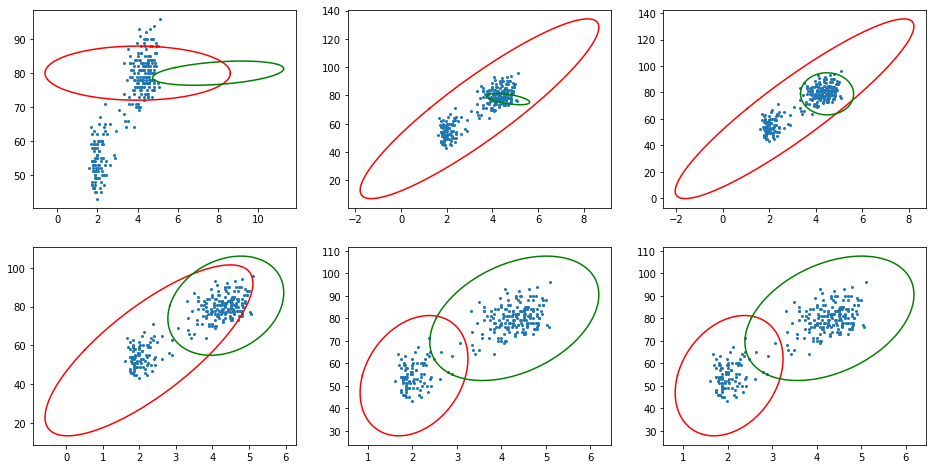

In [12]:
# make a true copy of our model
gmmcp = copy.deepcopy(gmm)

# create figure
plt.figure(figsize=(16, 8))
# improve model with EM-Algorithm
for i in range(5):
    # plot current status
    plt.subplot(231 + i)
    gmmplot(data, gmmcp)
    # excute EM-Algorithm
    for j in range(10):
        posterior = expectation(data, gmmcp)
        gmmcp = maximization(posterior, data, gmmcp)
# plot final status
plt.subplot(236)
gmmplot(data,gmmcp)